In [1]:
!git clone https://github.com/niazwazir/VTRG_Corona_Virus_Detection.git

Cloning into 'VTRG_Corona_Virus_Detection'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 222 (delta 32), reused 174 (delta 14), pack-reused 0
Receiving objects: 100% (222/222), 48.69 MiB | 12.70 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [2]:
cd VTRG_Corona_Virus_Detection/

/content/VTRG_Corona_Virus_Detection


In [3]:
#importing the necessary packages
import numpy as np
import cv2
import os
from imutils import paths
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, Xception, ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [4]:
#setting arguments 
args = {"dataset": "./dataset",
        "model": "corona.model"
       }

In [5]:
"""initializing the initial learning rate, epochs to train
   and batch size"""
learningRate = 1e-3
epochs = 500
batchSize = 8

In [6]:
"""listing out the images in the dataset folder, then initializing
   the list of data (images) and class images"""
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

#looping over the images paths
for imagePath in imagePaths:
    
    #extracting the class label from image paths
    label = imagePath.split(os.path.sep)[-2]

    """loading the images, changing color channels and resizing it to be a fixed
       224x224 pixels"""
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    #updating the data and labels lists
    data.append(image)
    labels.append(label)

"""converting the data and labels to NumPy arrays and scaling the pixel
   intensities to the range [0, 255]"""
data = np.array(data) / 255.0
labels = np.array(labels)

In [7]:
#using one-hot encoding on labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

"""splitting the data into training and testing using 80% of
   the data for training and 20% for testing"""
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, 
                                                  random_state=42)

#initializing the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

In [8]:
#loading the VGG16 network, ensuring the head FC layer sets are left
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
"""constructing the main model that will be placed on top of the
   the base model"""
mainModel = baseModel.output

mainModel = AveragePooling2D(pool_size=(4, 4))(mainModel)
mainModel = Flatten(name="flatten")(mainModel)
mainModel = Dense(64, activation="relu")(mainModel)
mainModel = Dropout(0.5)(mainModel)
mainModel = Dense(2, activation="softmax")(mainModel)

#lace the head FC model on top of the base model (actual model)
model = Model(inputs=baseModel.input, outputs=mainModel)

"""looping over all layers in the base model and freeze them so they will 
   not be updated during the first training process"""
for layer in baseModel.layers:
    layer.trainable = False

58900480/58889256 [==============================] - 2s 0us/step


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
import keras
import tensorflow as tf

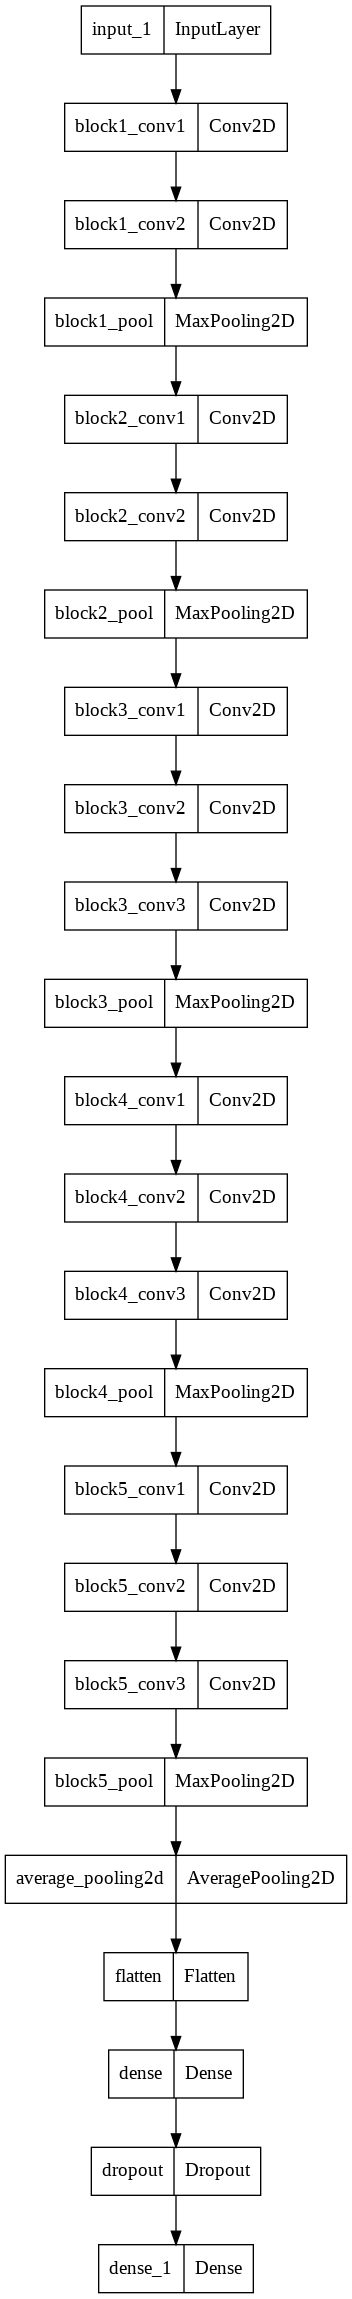

In [11]:
tf.keras.utils.plot_model(model, 'Wazir_first_model.png')

In [12]:
filename='log.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [13]:
#compiling up the model
optimizer = Adam(lr=learningRate, decay=learningRate / epochs)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
epochs = 500

In [15]:
history_const=model.fit(trainX, trainY,
              batch_size=batchSize,
              epochs=epochs,
              callbacks=[history_logger],
              validation_data=(trainX, trainY),
              shuffle=True)

Epoch 1/500
12/12 [==============================] - 18s 392ms/step - loss: 0.7523 - accuracy: 0.5667 - val_loss: 0.6477 - val_accuracy: 0.6556
Epoch 2/500
12/12 [==============================] - 3s 235ms/step - loss: 0.6165 - accuracy: 0.6444 - val_loss: 0.6189 - val_accuracy: 0.7889
Epoch 3/500
12/12 [==============================] - 3s 236ms/step - loss: 0.6227 - accuracy: 0.6667 - val_loss: 0.5927 - val_accuracy: 0.7889
Epoch 4/500
12/12 [==============================] - 3s 236ms/step - loss: 0.5612 - accuracy: 0.7000 - val_loss: 0.5675 - val_accuracy: 0.8111
Epoch 5/500
12/12 [==============================] - 3s 236ms/step - loss: 0.5668 - accuracy: 0.7889 - val_loss: 0.5457 - val_accuracy: 0.7778
Epoch 6/500
12/12 [==============================] - 3s 236ms/step - loss: 0.5328 - accuracy: 0.8111 - val_loss: 0.5194 - val_accuracy: 0.9333
Epoch 7/500
12/12 [==============================] - 3s 235ms/step - loss: 0.5355 - accuracy: 0.7667 - val_loss: 0.4973 - val_accuracy: 0.877

In [16]:
!ls

 dataset		      ResNet101V2_COVID_19.ipynb
'\dataset1'		      ResNet152_COVID_19.ipynb
 DenseNet121_COVID_19.ipynb   ResNet152V2_COVID_19.ipynb
 DenseNet169_COVID_19.ipynb   ResNet50V2_COVID_19.ipynb
 DenseNet201_COVID_19.ipynb   train_model.ipynb
 log.csv		      VGG16_COVID_19.ipynb
 output			      VGG19_COVID_19.ipynb
 README.md		      Wazir_first_model.png
 ResNet101_COVID_19.ipynb     Xception_COVID_19.ipynb


In [17]:
from google.colab import files
files.download('log.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>